In [28]:
import networkx as nx
import pandas
from data_processing import *
from modularity import cdr_graph
from matplotlib import pyplot as plt
import matplotlib.cm as cm

Load the data and build a projected Graph where nodes are CellId and edges are the number of sms sent in the same countries.

In [29]:
cdr_data = process_data('data/mobile-phone-activity/sms-call-internet-mi-2013-11-01.csv')
g = cdr_graph(cdr_data)

Function plotting the density in the blocks of a matrix, the darker the denser

In [30]:
def plot_matrix(matrix):
    plt.clf()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(matrix, interpolation='nearest', cmap=cm.Greys)
    plt.show()

Generates random clusters and plot it to see that the density is randomly distributed over the blocks. 
The adjacency matrix is normalized to obtain the joint probability matrix.
We display the log of the probability matrix to smooth density peaks and get a better visualisation.

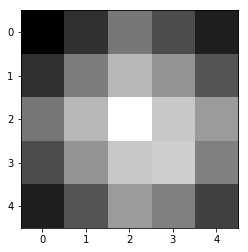

In [33]:
random_clusters = cdr_graph.random_partition([node-1 for node in g.graph.nodes], k=5)
random_cluster_adjacency_matrix = cdr_graph.build_cluster_adjacency_matrix(nx.to_numpy_matrix(g.graph), random_clusters)
random_log_probability_matrix = np.log(random_cluster_adjacency_matrix / float(random_cluster_adjacency_matrix.sum()))
plot_matrix(random_log_probability_matrix)

Here the information theoretical approach is performed to clusters the nodes: similar rows and columns are simultaneously grouped together to let appear the underlying structure in the graph.

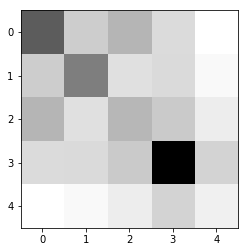

In [34]:
clusters, adjacency_matrix = g.information_theoretical_coclustering(nx.to_numpy_matrix(g.graph), k=5)
log_probability_matrix = np.log(adjacency_matrix / float(adjacency_matrix.sum()))
plot_matrix(probability_matrix)